# Case 2. Pneumonia X-ray image analysis
**Neural Networks for Machine Learning Applications**<br>
26.02.2023<br>
### Mateusz Czarnecki
### Julian Marco Soliveres
### Amal Kayed
[Information Technology, Bachelor's Degree](https://www.metropolia.fi/en/academics/bachelors-degrees/information-technology)<br>
[Metropolia University of Applied Sciences](https://www.metropolia.fi/en)

## 1. Introduction

The objectives of this Notebook is to practice the best convolutional neural networks model by creating a binary classifier for x-ray chest images to detect and diagnose pneumonia.

We developed three different CNN models to choose that achieves a minimum of 90% of both sensitivity and specificity in classification results.

## 2. Setup

In order to acomplish this assignment, we will use the following libraries
* numpy to perform mathematical and logical operations on arrays<br>
* pandas data analysis and associated manipulation of tabular data in DataFrames.<br>
* matplotlib for creating static, data visualization and graphical plotting.<br>
* glob a Python function to search and return all file paths that match a specific pattern.<br>
* os to interact and get Operating System information.<br>
* time for time series analysis in machine learning.<br>
* tensorflow to implement best practices for data automation, model tracking, performance monitoring, and model retraining.<br>
* sklearn for data mining and data analysis.

In [1]:
# Importing the required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input,MaxPooling2D,Dropout, GlobalAveragePooling2D,BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

## 3. Dataset

 Pneumonia is an inflammatory condition of the lung primarily affecting the small air sacs known as alveoli.<br> 
The dataset used is available on kaggle under the name Chest X-Ray Images (Pneumonia) on the following weblink
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia<br>
The dataset consists of three types of images normal, bacterial and  Pneumonia organized into three folders training contains 5216 images, validation contains 16 images and testing contains 624 images.

In [2]:
# Retrieve training data and store it in variable data_dir
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
case_dirs = os.listdir(data_dir) # returns a list containing the names of the entries in the directory data_dir
print(case_dirs) # print the list values

['PNEUMONIA', 'NORMAL']


In [3]:
# Retrieve testing data and store it in variable test_dir
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
case_dirs = os.listdir(test_dir)
print(case_dirs)

['PNEUMONIA', 'NORMAL']


In [4]:
# Create lists of the images
pneumonia_images   = glob(data_dir + "/PNEUMONIA/" + "*.jpeg")
normal_images = glob(data_dir + "/NORMAL/" + "*.jpeg")

In [5]:
# Count the number of cases
N_pneumonia = len(pneumonia_images)
N_normal = len(normal_images)
N_all = N_pneumonia + N_normal
print(f'Train cases:')
print(f'Pneumonia: {N_pneumonia :5d} ({N_pneumonia/N_all*100 :5.1f} %)')
print(f'Normal:    {N_normal :5d} ({N_normal/N_all*100 :5.1f} %)')
print(f'Total:     {N_all  :5d} ({N_all/N_all*100  :5.1f} %)')

Train cases:
Pneumonia:  3875 ( 74.3 %)
Normal:     1341 ( 25.7 %)
Total:      5216 (100.0 %)


In [6]:
# Function to show the images in the training data and their classes  
def show_imgs(num_of_imgs):
    
    for img in range(num_of_imgs):
        pneu_pic   = np.asarray(plt.imread(pneumonia_images[img]))
        normal_pic = np.asarray(plt.imread(normal_images[img]))

        fig = plt.figure(figsize= (7,5))

        normal_plot = fig.add_subplot(1,2,1)
        plt.imshow(normal_pic, cmap='gray')
        normal_plot.set_title('Normal')
        plt.axis('off')

        pneu_plot = fig.add_subplot(1, 2, 2)
        plt.imshow(pneu_pic, cmap='gray')
        pneu_plot.set_title('Pneumonia')
        plt.axis('off')
    
        plt.show()

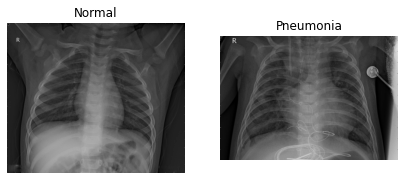

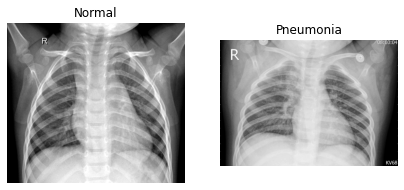

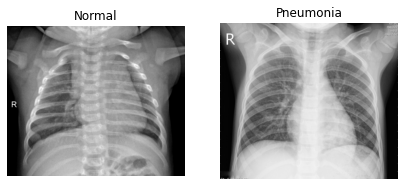

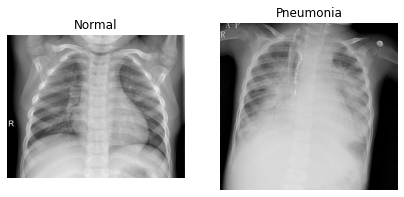

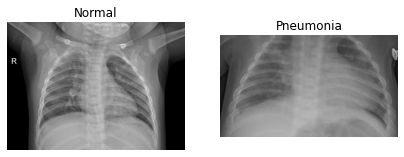

In [7]:
show_imgs(5) # Show the first five images

## 4. Preprocessing

- how the missing values are handled

When the image is rotated, empty pixels will be filled in by using the nearest pixel values specified in the fill_mode argument.

- conversion of textual and categorical data into numerical values (if needed)

Dataset has two classes Normal and Pneumonia, by setting up class_mode='binary' target data changed to 0 for class Normal and 1 for class Pneumonia.

- how the data is splitted into train, validation and test sets

As the validation data contains only 16 images, we used a part of training data for validation process instead of the default images. We split training set into 80% (4173 images) for training and 20% (1043 images) for validation. 

- the features (=input) and labels (=output), and 
- how the features are normalized or scaled

The features are Chest X-Ray Images and the labels are two classes Normal or Pneumonia. The pixel values of each image in the training, validation and testing sets falls in the range of 0 to 255. These values were scaled to a range of 0 to 1 before feeding them to the neural network model by dividing the values by 255.

In [8]:
# Settings for the data generators
BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)

In [9]:
# Using ImageDataGenerator to load the images the model and setting up parameters of data augmentation
traingen=ImageDataGenerator(rescale=1/255.,
                           rotation_range=0.05,
                           brightness_range=[0.2,1.2],
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           horizontal_flip=True,
                           fill_mode = 'nearest',
                           #zoom_range = 0.1,
                           validation_split = 0.2,)


testgen=ImageDataGenerator(rescale=1/255.)

valgen=ImageDataGenerator(rescale=1/255.,
                         validation_split = 0.2,)

In [10]:
# Stores training images in variable traindata
traindata=traingen.flow_from_directory(data_dir,
                                       target_size=IMAGE_SIZE,
                                       batch_size = BATCH_SIZE,
                                       shuffle=True,class_mode='binary',
                                       subset = "training")

# Stores testing images in variable testdata
testdata=testgen.flow_from_directory(test_dir,
                                    shuffle=False,batch_size = BATCH_SIZE,
                                    target_size=IMAGE_SIZE,
                                    class_mode="binary",)

# Stores validation images in variable valdata
valdata=valgen.flow_from_directory(data_dir,
                                    shuffle=False,batch_size = BATCH_SIZE,
                                    target_size=IMAGE_SIZE,
                                    class_mode="binary",
                                    subset = "validation")

Found 4173 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [11]:
df=pd.DataFrame(traindata.classes) #load traindata into a DataFrame object
df.value_counts() # print the number of Normal (0) and Pneumonia (1) cases

1    3100
0    1073
dtype: int64

In [12]:
df=pd.DataFrame(valdata.classes) #load valdata into a DataFrame object
df.value_counts() # print the number of Normal (0) and Pneumonia (1) cases

1    775
0    268
dtype: int64

In [13]:
df=pd.DataFrame(testdata.classes) #load testdata into a DataFrame object
df.value_counts() # print the number of Normal (0) and Pneumonia (1) cases

1    390
0    234
dtype: int64

## 5. Modeling

In [14]:
IMG_SHAPE = IMAGE_SIZE + (3,)

## 1. Sequential and pre-trained DenseNet model "MobileNetV2"

We structured this model in a way it has three convolutional layers along with "relu" and "sigmoid" classifiers and mobilenetV2 layer and in between these layers we used Batchnormalization layerto speed up training and use higher learning rates and Dropout layer to prevent overfitting.

In [66]:
# Using Sequential model with MobileNetV2 for for better accuracy
base_MobileNetV2 = MobileNetV2(weights = 'imagenet',
                               pooling='avg', 
                               include_top = False, 
                               input_shape = IMG_SHAPE)

tf.keras.backend.clear_session()
    
for layer in base_MobileNetV2.layers:
    layer.trainable =  False # freezing densenet layers

model1 = Sequential()
model1.add(base_MobileNetV2)
#model1.add(GlobalAveragePooling2D())
model1.add(BatchNormalization())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(BatchNormalization())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 1280)              2257984   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

## 2. Sequential and pre-trained DenseNet model "DenseNet169"

We structured this model in a way it has three convolutional layers along with "relu" and "sigmoid" classifiers and densenet169 layer and in between these layers we used Batchnormalization layerto speed up training and use higher learning rates and Dropout layer to prevent overfitting. 

In [22]:
# Using Sequential model with DenseNet169 for for better accuracy 

base_DenseNet169 = DenseNet169(weights = 'imagenet',
                               pooling='avg', 
                               include_top = False, 
                               input_shape = IMG_SHAPE)

tf.keras.backend.clear_session()

for layer in base_DenseNet169.layers:
    layer.trainable =  False # freezing densenet layers 

model2 = Sequential()
model2.add(base_DenseNet169)
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
batch_normalization (BatchNo (None, 1664)              6656      
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

## 3. Sequential with pooling layers

We structured this model in a way it has three convolutional layers with "relu" and "sigmoid" classifiers. The number of filters of each layer was increased slightly. The first layer is using filter of size 5X5 as the input images are bigger than 128X128. Max pooling was used after each layer to reduce the spatial dimensions of the output volume. In the final layer a single fully connected layer was added with 512 nodes followed by dropoutlayer.

In [59]:
tf.keras.backend.clear_session()

model3 = Sequential() # Create an object of Sequential

model3.add(Conv2D(32, (5,5), 1, activation='relu', input_shape=(160, 160, 3)))
model3.add(MaxPooling2D())
model3.add(Conv2D(64, (3,3), 1, activation='relu'))
model3.add(MaxPooling2D())
model3.add(Conv2D(128, (3,3), 1, activation='relu'))
model3.add(MaxPooling2D())
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 156, 156, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 78, 78, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 76, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

## 6. Training

All the models were compiled to use optimizer: Adam, loss: BinaryCrossentropy, metrics: Accuracy, Recall, TrueNegatives, FalsePositives.
Also all the models were trained by feeding the training data and using validation data to validate the their performance during training and each model was traind with the suitable number of epochs, where the accuracy does not increase after it.             
    

## Model 1

In [67]:
t1 = time.time()

optm = tf.keras.optimizers.Adam(learning_rate=0.0001)

model1.compile(loss='binary_crossentropy', 
                        optimizer=optm, 
                        metrics=['Accuracy','Recall','TrueNegatives', 'FalsePositives'])

his1 = model1.fit(traindata,
                           epochs = 25,
                           validation_data = valdata,
                                       )

print(f'Training time: {time.time()-t1} seconds')
print(f'Training time: {(time.time()-t1)/60} minutes')

print('\nAccuracy:',his1.history['Accuracy'][-1])
print('Recall:',his1.history['recall'][-1])
print('Specificity', his1.history['true_negatives'][-1] / (his1.history['false_positives'][-1] + his1.history['true_negatives'][-1]))

print('\nVal Accuracy:',his1.history['val_Accuracy'][-1])
print('Val Recall:',his1.history['val_recall'][-1])
print('Val Specificity', his1.history['val_true_negatives'][-1] / (his1.history['val_false_positives'][-1] + his1.history['val_true_negatives'][-1]))

Epoch 1/25
131/131 [==============================] - 128s 945ms/step - loss: 0.5599 - Accuracy: 0.7366 - recall: 0.8039 - true_negatives: 582.0000 - false_positives: 491.0000 - val_loss: 0.3842 - val_Accuracy: 0.8456 - val_recall: 0.8052 - val_true_negatives: 258.0000 - val_false_positives: 10.0000
Epoch 2/25
131/131 [==============================] - 121s 924ms/step - loss: 0.3649 - Accuracy: 0.8390 - recall: 0.8774 - true_negatives: 781.0000 - false_positives: 292.0000 - val_loss: 0.3183 - val_Accuracy: 0.8619 - val_recall: 0.8219 - val_true_negatives: 262.0000 - val_false_positives: 6.0000
Epoch 3/25
131/131 [==============================] - 122s 930ms/step - loss: 0.3106 - Accuracy: 0.8653 - recall: 0.9045 - true_negatives: 807.0000 - false_positives: 266.0000 - val_loss: 0.2805 - val_Accuracy: 0.8821 - val_recall: 0.8465 - val_true_negatives: 264.0000 - val_false_positives: 4.0000
Epoch 4/25
131/131 [==============================] - 120s 922ms/step - loss: 0.2706 - Accuracy: 0.

## Model 2

In [23]:
t2 = time.time()

optm = tf.keras.optimizers.Adam(learning_rate=0.0001)

model2.compile(
    optimizer=optm,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['Accuracy','Recall','TrueNegatives', 'FalsePositives']
)
his2 = model2.fit(traindata,
                  epochs=20,
                  validation_data=valdata)
print(f'Training time: {time.time()-t2} seconds')
print(f'Training time: {(time.time()-t2)/60} minutes')

print('\nAccuracy:',his2.history['Accuracy'][-1])
print('Recall:',his2.history['recall'][-1])
print('Specificity', his2.history['true_negatives'][-1] / (his2.history['false_positives'][-1] + his2.history['true_negatives'][-1]))

print('\nVal Accuracy:',his2.history['val_Accuracy'][-1])
print('Val Recall:',his2.history['val_recall'][-1])
print('Val Specificity', his2.history['val_true_negatives'][-1] / (his2.history['val_false_positives'][-1] + his2.history['val_true_negatives'][-1]))

Epoch 1/20
131/131 [==============================] - 286s 2s/step - loss: 0.6250 - Accuracy: 0.6722 - recall: 0.6303 - true_negatives: 851.0000 - false_positives: 222.0000 - val_loss: 0.4702 - val_Accuracy: 0.7872 - val_recall: 0.7174 - val_true_negatives: 265.0000 - val_false_positives: 3.0000
Epoch 2/20
131/131 [==============================] - 273s 2s/step - loss: 0.4395 - Accuracy: 0.8040 - recall: 0.7697 - true_negatives: 969.0000 - false_positives: 104.0000 - val_loss: 0.4184 - val_Accuracy: 0.8198 - val_recall: 0.7600 - val_true_negatives: 266.0000 - val_false_positives: 2.0000
Epoch 3/20
131/131 [==============================] - 272s 2s/step - loss: 0.3653 - Accuracy: 0.8521 - recall: 0.8284 - true_negatives: 988.0000 - false_positives: 85.0000 - val_loss: 0.3378 - val_Accuracy: 0.8725 - val_recall: 0.8323 - val_true_negatives: 265.0000 - val_false_positives: 3.0000
Epoch 4/20
131/131 [==============================] - 266s 2s/step - loss: 0.3065 - Accuracy: 0.8859 - recall:

## Model3

In [60]:
t3 = time.time()

optm = tf.keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(optimizer=optm, 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['Accuracy','Recall','TrueNegatives', 'FalsePositives'])

# Training the Convolution Neural Network
his3 = model3.fit(traindata, 
                   epochs=15, 
                   validation_data=valdata)

print(f'Training time: {time.time()-t3} seconds')
print(f'Training time: {(time.time()-t3)/60} minutes')

print('\nAccuracy:',his3.history['Accuracy'][-1])
print('Recall:',his3.history['recall'][-1])
print('Specificity', his3.history['true_negatives'][-1] / (his3.history['false_positives'][-1] + his3.history['true_negatives'][-1]))

print('\nVal Accuracy:',his3.history['val_Accuracy'][-1])
print('Val Recall:',his3.history['val_recall'][-1])
print('Val Specificity', his3.history['val_true_negatives'][-1] / (his3.history['val_false_positives'][-1] + his3.history['val_true_negatives'][-1]))

Epoch 1/15
131/131 [==============================] - 168s 1s/step - loss: 0.4889 - Accuracy: 0.7812 - recall: 0.9697 - true_negatives: 254.0000 - false_positives: 819.0000 - val_loss: 0.2346 - val_Accuracy: 0.9128 - val_recall: 0.9265 - val_true_negatives: 234.0000 - val_false_positives: 34.0000
Epoch 2/15
131/131 [==============================] - 165s 1s/step - loss: 0.3366 - Accuracy: 0.8620 - recall: 0.9426 - true_negatives: 675.0000 - false_positives: 398.0000 - val_loss: 0.1982 - val_Accuracy: 0.9156 - val_recall: 0.8929 - val_true_negatives: 263.0000 - val_false_positives: 5.0000
Epoch 3/15
131/131 [==============================] - 164s 1s/step - loss: 0.2381 - Accuracy: 0.9056 - recall: 0.9532 - true_negatives: 824.0000 - false_positives: 249.0000 - val_loss: 0.1720 - val_Accuracy: 0.9291 - val_recall: 0.9110 - val_true_negatives: 263.0000 - val_false_positives: 5.0000
Epoch 4/15
131/131 [==============================] - 164s 1s/step - loss: 0.2159 - Accuracy: 0.9140 - recal

## 7. Performance and evaluation

### Loss and Val loss

The loss curves below shows that the performance of model1 and model2 are better than mosdel3 as its prediction loss of the validation data varies greatly with big oscillation, which means validation set is likely not enough or not representative of the whole dataset.

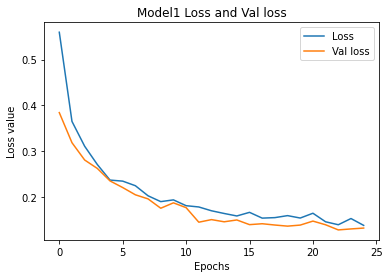

In [68]:
# Plotting Loss and and val loss Curves from training and validation "model 1"
plt.plot(his1.history['loss'], label='Loss')
plt.plot(his1.history['val_loss'], label='Val loss')
plt.title('Model1 Loss and Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

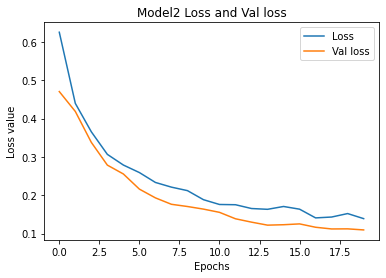

In [24]:
# Plotting Loss and and val loss Curves from training and validation "model 2"
plt.plot(his2.history['loss'], label='Loss')
plt.plot(his2.history['val_loss'], label='Val loss')
plt.title('Model2 Loss and Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

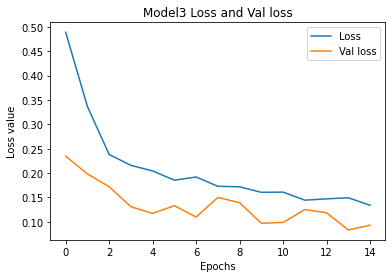

In [61]:
# Plotting Loss and and val loss Curves from training and validation "model 3"
plt.plot(his3.history['loss'], label='Loss')
plt.plot(his3.history['val_loss'], label='Val loss')
plt.title('Model3 Loss and Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### Accuracy and Val accuracy

The accuracy curves below also shows that the performance of model1 and model2 are better than mosdel3 as its prediction accuracy of the validation data varies greatly with big oscillation at some epochs, and then gradually converges to a higher accuracy level with much small oscillation between at some other epochs, which indicates that learning is happening during different epochs.

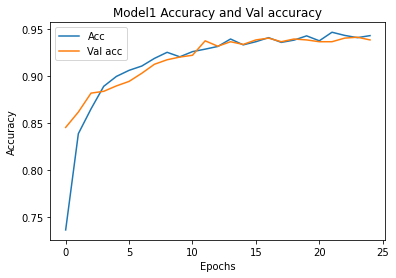

In [69]:
# Plotting Accuracy and val Accuracy Curves from training and validation "model 1"
plt.plot(his1.history['Accuracy'], label='Acc')
plt.plot(his1.history['val_Accuracy'], label='Val acc')
plt.title('Model1 Accuracy and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

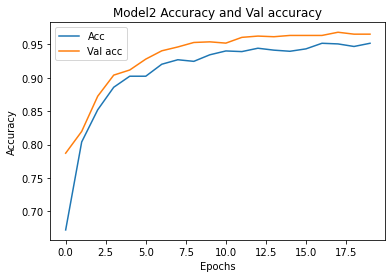

In [25]:
# Plotting Accuracy and val Accuracy Curves from training and validation "model 2"
plt.plot(his2.history['Accuracy'], label='Acc')
plt.plot(his2.history['val_Accuracy'], label='Val acc')
plt.title('Model2 Accuracy and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

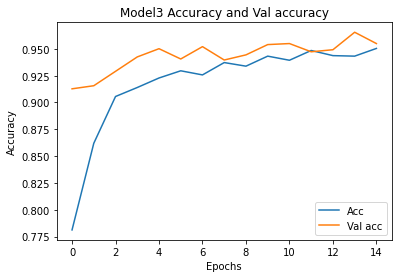

In [62]:
# Plotting Accuracy and val Accuracy Curves from training and validation "model 3"
plt.plot(his3.history['Accuracy'], label='Acc')
plt.plot(his3.history['val_Accuracy'], label='Val acc')
plt.title('Model3 Accuracy and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Sensitivity and val Sensitivity

The Sensitivity curves below shows that the prediction Sensitivity of the validation data is the best in model2 and then model1, while it continues with much small oscillation in model3

(0.0, 1.0)

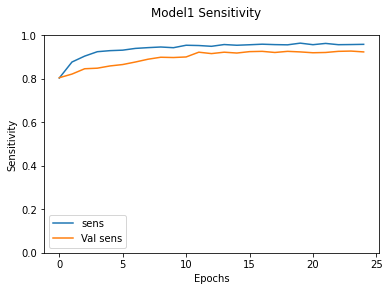

In [70]:
# Plotting Sensitivity and val Sensitivity Curves from training and validation for model 1
sensitivity1 = his1.history['recall']
val_sensitivity1 = his1.history['val_recall']

false_positives1 = his1.history['false_positives']
val_false_positives1 = his1.history['val_false_positives']

true_negatives1 = his1.history['true_negatives']
val_true_negatives1 = his1.history['val_true_negatives']

specificity1 = []
val_specificity1 = []

for i in range(0, len(false_positives1)):
    specificity1.append(true_negatives1[i] / (false_positives1[i] + true_negatives1[i]))
    
for i in range(0, len(val_false_positives1)):
    val_specificity1.append(val_true_negatives1[i] / (val_false_positives1[i] + val_true_negatives1[i]))


plt.plot(sensitivity1, label='sens')
plt.plot(val_sensitivity1, label='Val sens')
plt.legend()
plt.suptitle('Model1 Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.ylim([0, 1])

(0.0, 1.0)

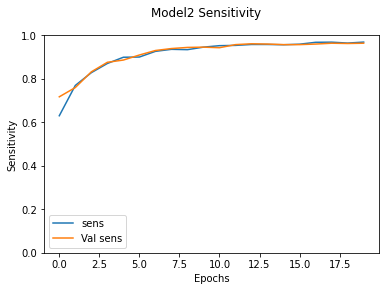

In [45]:
# Plotting Sensitivity and val Sensitivity Curves from training and validation for model 2
sensitivity2 = his2.history['recall']
val_sensitivity2 = his2.history['val_recall']

false_positives2 = his2.history['false_positives']
val_false_positives2 = his2.history['val_false_positives']

true_negatives2 = his2.history['true_negatives']
val_true_negatives2 = his2.history['val_true_negatives']

specificity2 = []
val_specificity2 = []

for i in range(0, len(false_positives2)):
    specificity2.append(true_negatives2[i] / (false_positives2[i] + true_negatives2[i]))
    
for i in range(0, len(val_false_positives2)):
    val_specificity2.append(val_true_negatives2[i] / (val_false_positives2[i] + val_true_negatives2[i]))


plt.plot(sensitivity2, label='sens')
plt.plot(val_sensitivity2, label='Val sens')
plt.legend()
plt.suptitle('Model2 Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.ylim([0, 1])

(0.0, 1.0)

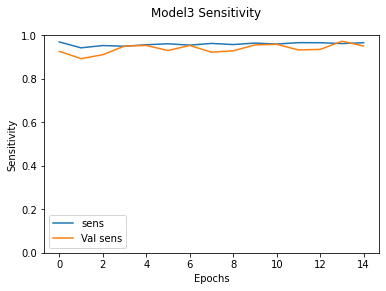

In [63]:
# Plotting Sensitivity and val Sensitivity Curves from training and validation for model 3
sensitivity3 = his3.history['recall']
val_sensitivity3 = his3.history['val_recall']

false_positives3 = his3.history['false_positives']
val_false_positives3 = his3.history['val_false_positives']

true_negatives3 = his3.history['true_negatives']
val_true_negatives3 = his3.history['val_true_negatives']

specificity3 = []
val_specificity3 = []

for i in range(0, len(false_positives3)):
    specificity3.append(true_negatives3[i] / (false_positives3[i] + true_negatives3[i]))
    
for i in range(0, len(val_false_positives3)):
    val_specificity3.append(val_true_negatives3[i] / (val_false_positives3[i] + val_true_negatives3[i]))


plt.plot(sensitivity3, label='sens')
plt.plot(val_sensitivity3, label='Val sens')
plt.legend()
plt.suptitle('Model3 Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.ylim([0, 1])

### Specificity and val Specificity

The Specificity curves below shows that the prediction Specificity of the validation data data varies greatly with big oscillation in model3, which indicates that validation data is likely not enough or not representative of the whole dataset. While model1 and two achieved better specificity, but higher in model2 than model1. 

(0.0, 1.0)

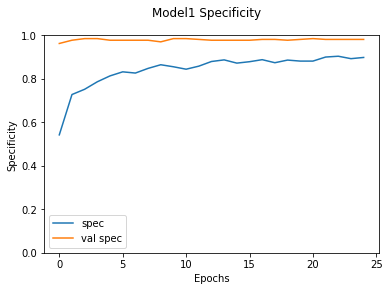

In [71]:
# Plotting Specificity and val Specificity Curves from training and validation for model 1
plt.plot(specificity1, label='spec')
plt.plot(val_specificity1, label='val spec')
plt.legend()
plt.suptitle('Model1 Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.ylim([0, 1])

(0.0, 1.0)

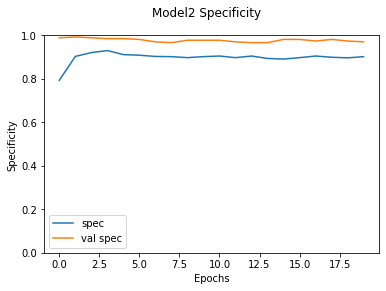

In [73]:
# Plotting Specificity and val Specificity Curves from training and validation for model 2
plt.plot(specificity2, label='spec')
plt.plot(val_specificity2, label='val spec')
plt.legend()
plt.suptitle('Model2 Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.ylim([0, 1])

(0.0, 1.0)

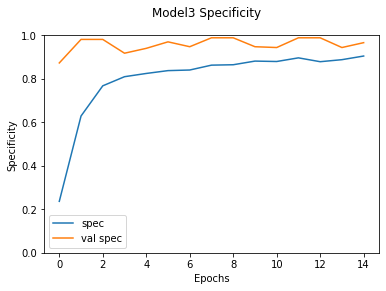

In [74]:
# Plotting Specificity and val Specificity Curves from training and validation for model 3
plt.plot(specificity3, label='spec')
plt.plot(val_specificity3, label='val spec')
plt.legend()
plt.suptitle('Model3 Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.ylim([0, 1])

### Models  Evaluating using the test set

After training the models, we tested their performance using test data, which does not involve in the model training and validation process and we got the results shown below.

In [72]:
# Evaluating model1 using the test set
test_evaluation = model1.evaluate(testdata)

print()
print('----------------------------------')
print('Summary performance indicators:')
print('----------------------------------')
print('\nLoss function: ', test_evaluation[0])
print('Accuracy: ', test_evaluation[1])
print('Sensitivity: ', test_evaluation[2])
true_negatives = test_evaluation[3]
false_positives = test_evaluation[4]
print('Specificity: ', true_negatives / (true_negatives + false_positives))

20/20 [==============================] - 10s 451ms/step - loss: 0.3143 - Accuracy: 0.8782 - recall: 0.9692 - true_negatives: 170.0000 - false_positives: 64.0000

----------------------------------
Summary performance indicators:
----------------------------------

Loss function:  0.3143281936645508
Accuracy:  0.8782051205635071
Sensitivity:  0.9692307710647583
Specificity:  0.7264957264957265


In [50]:
# Evaluating model2 using the test set
test_evaluation = model2.evaluate(testdata)

print()
print('----------------------------------')
print('Summary performance indicators:')
print('----------------------------------')
print('\nLoss function: ', test_evaluation[0])
print('Accuracy: ', test_evaluation[1])
print('Sensitivity: ', test_evaluation[2])
true_negatives = test_evaluation[3]
false_positives = test_evaluation[4]
print('Specificity: ', true_negatives / (true_negatives + false_positives))

20/20 [==============================] - 33s 1s/step - loss: 0.3430 - Accuracy: 0.8734 - recall: 0.9872 - true_negatives: 160.0000 - false_positives: 74.0000

----------------------------------
Summary performance indicators:
----------------------------------

Loss function:  0.3429514467716217
Accuracy:  0.8733974099159241
Sensitivity:  0.9871794581413269
Specificity:  0.6837606837606838


In [65]:
# Evaluating model3 using the test set
test_evaluation = model3.evaluate(testdata)

print()
print('----------------------------------')
print('Summary performance indicators:')
print('----------------------------------')
print('\nLoss function: ', test_evaluation[0])
print('Accuracy: ', test_evaluation[1])
print('Sensitivity: ', test_evaluation[2])
true_negatives = test_evaluation[3]
false_positives = test_evaluation[4]
print('Specificity: ', true_negatives / (true_negatives + false_positives))

20/20 [==============================] - 10s 450ms/step - loss: 0.6978 - Accuracy: 0.7500 - recall: 0.9692 - true_negatives: 90.0000 - false_positives: 144.0000

----------------------------------
Summary performance indicators:
----------------------------------

Loss function:  0.6977663040161133
Accuracy:  0.75
Sensitivity:  0.9692307710647583
Specificity:  0.38461538461538464


## 8. Discussion and conclusions

Instructions: Write

- What settings and models were tested before the best model was found
    - What where the results of these experiments 
    
    We tested the three models with various epochs and layers, sometimes the results were almost similar     with tiny differences and some other times we got diffrent results. We also noticed that changing the paramerters of ImageDataGenerator will affect the results. 
    
- Summary of  
    - What was your best model and its settings 
    - What was the final achieved performance 
    
    For performance accuracy, the second model (model2) was the best as it achieved 
    
   * Accuracy: 0.951833188533783
   * Recall: 0.9690322875976562
   * Specificity 0.902143522833178

   * Val Accuracy: 0.9654842019081116
   * Val Recall: 0.9638709425926208
   * Val Specificity 0.9701492537313433
   
   But, if we consider the time as an important factor, then the first model (model1) was the best as it    achieved good results, but in shorter time and more epochs and better Evaluating using test data.
    
- What are your main observations and learning points

For images bigger than 128X128 better to use filter of size 5X5 or 7X7 for the first layer for faster and deeper learning. Rotating and zooming images to big angles will cause bigger oscillations. Increasing the number of layers and neurons will improve the learning and results.

- Discussion how the model could be improved in future 

An artificially inflated dataset is never as good as real images, because it contains much of the same information as its original, so expanding dataset with additional high-quality validation and testing data is a good approach to improve the performance of CNN model.

Randomize the training data order by shuffling it between epochs to avoid potential biases when presenting data in a fixed order over all iterations during training. Also improving the network design by adding more convolution layers to help the network identify more meaningful patterns.
